# Preenchimento Híbrido
Mostra o comportamento da rede utilizando os dois tipos de preenchimento. Essa simulação registra os recursos utilizados:

    - Número de Qubits criados
    - Número de EPRs criados  

In [1]:
# Importando as dependências
from quantumnet.components import Controller, Network
from quantumnet.utils import generate_random_request, register_consumption, clear_file
from quantumnet.objects import time

Informações para a simulação

In [2]:
# Caminho do arquivo de saída
path = "resultados/hibrido/qubits_eprs_sync.csv"
# Limpa o arquivo de saída
clear_file(path)
# Sobre a rede
rede = Network()
rede.n_initial_eprs = 10
rede.n_initial_qubits = 10
row, col = 3, 4
rede.set_ready_topology("Grade", (row, col))
# Sobre o controlador
controlador = Controller(rede)
controlador.default_ttl = 100
# Sobre as requisições
fmin_range = (0.5, 1)
neprs_range = (2, 4)
num_requests = 100
requests = list(generate_random_request(len(rede.hosts)-1, fmin_range, neprs_range) for i in range(num_requests))

Preenchimento proativo

In [3]:
hosts = rede.hosts
for alice in hosts:
    for bob in hosts:
        controlador.add_match_route_rule_in_host_proactive(alice, bob, (0.5, 0.6), 5)
        controlador.add_match_route_rule_in_host_proactive(alice, bob, (0.8, 0.9), 5)

Funções responsáveis pela passagem de tempo

In [4]:
def update_time(time_for_update):
    """
    Atualiza o tempo e as regras

    Args:
        time_for_update (int): Tempo para incrementar o time-slot.
    """
    # Atualiza o tempo
    for t in range(time_for_update):
        time.increment()
        
        # Registra o consumo de recursos
        register_consumption(time.get_current_time(), rede.registry_of_resources, path)
        
        # Atualiza os recursos de 10 em 10
        if time.get_current_time() % 10 == 0:
            rede.refresh_resources(num_qubits=10, num_eprs=10)
            print(f"[Time {time.get_current_time()}] Recursos atualizados")

Preenchimento reativo, baseado nas requests.

    - Demora 1 time-slot se a regra existe.
    - Demora 3 time-slots se uma nova regra precisa ser adicionada.

In [5]:
for request in requests:
        print(f"[Time {time.get_current_time()}] Processando requisição {request}...")
        alice = rede.get_host(request.alice)
        rule = alice.find_rule_by_request(request)

        if rule == False:  # Caso não exista um match na tabela
            request.starttime = time.get_current_time()
            update_time(3)
            controlador.add_match_route_rule_in_host_reactive(request)
            rule = alice.find_rule_by_request(request)
            controlador.run_rule(rule[1])
            request.endtime = time.get_current_time() 
            
        else:  # Caso já exista a regra
            request.starttime = time.get_current_time()
            update_time(1)
            controlador.run_rule(rule[1])
            request.endtime = time.get_current_time()
        
        # Exibir informações da requisição
        print(f"Request {request}: Start Time = {request.starttime}, End Time = {request.endtime}")

[Time 0] Processando requisição R-334290...
Time-slot 1 registrado: Qubits = 120, EPRs = 170
Time-slot 2 registrado: Qubits = 120, EPRs = 170
Time-slot 3 registrado: Qubits = 120, EPRs = 170
Decisão aplicada: (High Fidelity,)
Request R-334290: Start Time = 0, End Time = 3
[Time 3] Processando requisição R-78EB10...
Time-slot 4 registrado: Qubits = 120, EPRs = 170
[BasicRuleProactive] Passo: 1
[BasicRuleProactive] Ação: CreateEPR(5-4)
[BasicRuleProactive] Ação: CreateEPR(4-8)
[BasicRuleProactive] Passo: 2
[BasicRuleProactive] Ação: Swap(5-4-8)
Running Swap(5-4-8)
Request R-78EB10: Start Time = 3, End Time = 4
[Time 4] Processando requisição R-F03CE0...
Time-slot 5 registrado: Qubits = 120, EPRs = 172
Time-slot 6 registrado: Qubits = 120, EPRs = 172
Time-slot 7 registrado: Qubits = 120, EPRs = 172
Decisão aplicada: (Normal E2E,)
[BasicRule] Passo: 1
Request R-F03CE0: Start Time = 4, End Time = 7
[Time 7] Processando requisição R-334590...
Time-slot 8 registrado: Qubits = 120, EPRs = 172


In [6]:
memory = rede.get_host(1).memory
for q in memory:
    print("Tempo de criação do qubit", q._creation_time)
    print("Tempo de vida", q._life_time)
    print("Fidelidade atual do qubit", q.get_current_fidelity())
    print("Qubit relaxado?", q._relaxed)
    print()

Tempo de criação do qubit 0
Tempo de vida 242
Fidelidade atual do qubit 0.08892161745938634
Qubit relaxado? True

Tempo de criação do qubit 0
Tempo de vida 242
Fidelidade atual do qubit 0.08892161745938634
Qubit relaxado? True

Tempo de criação do qubit 0
Tempo de vida 242
Fidelidade atual do qubit 0.08892161745938634
Qubit relaxado? True

Tempo de criação do qubit 0
Tempo de vida 242
Fidelidade atual do qubit 0.08892161745938634
Qubit relaxado? True

Tempo de criação do qubit 0
Tempo de vida 242
Fidelidade atual do qubit 0.08892161745938634
Qubit relaxado? True

Tempo de criação do qubit 0
Tempo de vida 242
Fidelidade atual do qubit 0.08892161745938634
Qubit relaxado? True

Tempo de criação do qubit 0
Tempo de vida 242
Fidelidade atual do qubit 0.08892161745938634
Qubit relaxado? True

Tempo de criação do qubit 0
Tempo de vida 242
Fidelidade atual do qubit 0.08892161745938634
Qubit relaxado? True

Tempo de criação do qubit 0
Tempo de vida 242
Fidelidade atual do qubit 0.08892161745938

In [7]:
eprs = rede.edges[0, 1]['eprs']
for epr in eprs:
    print("Tempo de criação do EPR", epr._creation_time)
    print("Tempo de vida", epr._life_time)
    print("Fidelidade atual do EPR", epr.get_current_fidelity())
    print("EPR relaxado?", epr._relaxed)
    print()

Tempo de criação do EPR 0
Tempo de vida 242
Fidelidade atual do EPR 0.08892161745938634
EPR relaxado? True

Tempo de criação do EPR 0
Tempo de vida 242
Fidelidade atual do EPR 0.08892161745938634
EPR relaxado? True

Tempo de criação do EPR 0
Tempo de vida 242
Fidelidade atual do EPR 0.08892161745938634
EPR relaxado? True

Tempo de criação do EPR 0
Tempo de vida 242
Fidelidade atual do EPR 0.08892161745938634
EPR relaxado? True

Tempo de criação do EPR 10
Tempo de vida 232
Fidelidade atual do EPR 0.09827358560436154
EPR relaxado? True

Tempo de criação do EPR 10
Tempo de vida 232
Fidelidade atual do EPR 0.09827358560436154
EPR relaxado? True

Tempo de criação do EPR 10
Tempo de vida 232
Fidelidade atual do EPR 0.09827358560436154
EPR relaxado? True

Tempo de criação do EPR 10
Tempo de vida 232
Fidelidade atual do EPR 0.09827358560436154
EPR relaxado? True

Tempo de criação do EPR 10
Tempo de vida 232
Fidelidade atual do EPR 0.09827358560436154
EPR relaxado? True

Tempo de criação do EPR

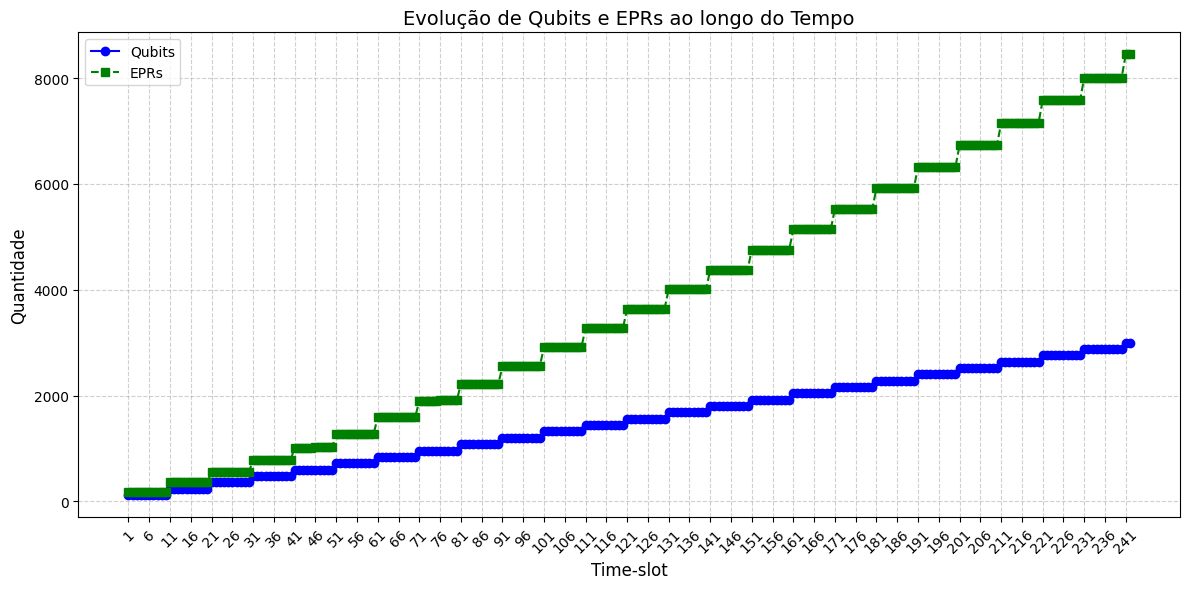

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_qubits_eprs(csv_file):
    """
    Lê um arquivo CSV sem cabeçalhos e plota gráficos mostrando a relação entre tempo (time-slot),
    qubits e EPRs, com o eixo X exibindo apenas valores de 5 em 5.
    
    Parâmetros:
        csv_file (str): Caminho para o arquivo CSV.
    """
    # Lê o arquivo CSV sem cabeçalhos
    data = pd.read_csv(csv_file, header=None, names=['time-slot', 'qubits', 'eprs'])

    # Cria o gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(data['time-slot'], data['qubits'], label='Qubits', marker='o', linestyle='-', color='blue')
    plt.plot(data['time-slot'], data['eprs'], label='EPRs', marker='s', linestyle='--', color='green')
    
    # Configurações do gráfico
    plt.title('Evolução de Qubits e EPRs ao longo do Tempo', fontsize=14)
    plt.xlabel('Time-slot', fontsize=12)
    plt.ylabel('Quantidade', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(visible=True, linestyle='--', alpha=0.6)

    # Configuração do eixo X para mostrar de 5 em 5
    xticks = data['time-slot'][::5]  # Pega os valores de time-slot a cada 5 linhas
    plt.xticks(xticks, labels=xticks, rotation=45)

    plt.tight_layout()
    
    # Exibe o gráfico
    plt.show()

plot_qubits_eprs(path)
# Exemplo de uso
# Salve o CSV no caminho 'dados.csv' e use:
# plot_qubits_eprs('dados.csv')